In [2]:
!pip install kaggle

In [1]:

from google.colab import files
files.upload()




Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username": "AbinayaB04", "key": "KGAT_ceec7b63217294cd9e537d0a9135b5e3"}'}

In [3]:
import os

In [4]:
os.makedirs('/root/.kaggle',exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images


Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 66% 69.0M/105M [00:00<00:00, 703MB/s]
100% 105M/105M [00:00<00:00, 646MB/s] 


In [7]:
import zipfile
with zipfile.ZipFile('cifake-real-and-ai-generated-synthetic-images.zip', 'r') as zip_ref:
    zip_ref.extractall('./cifake')

In [8]:
for root, dirs, files in os.walk('./cifake'):
  level=root.replace('./cifake','').count(os.sep)
  indent=' '*2*level
  print(f'{indent}{os.path.basename(root)}/')
  if level==2:
    print(f'{indent}--> {len(files)} images')

cifake/
  test/
    REAL/
    --> 10000 images
    FAKE/
    --> 10000 images
  train/
    REAL/
    --> 50000 images
    FAKE/
    --> 50000 images


In [9]:
import torch
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,random_split

In [10]:
train_transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
]
)

In [11]:
#loading dataset
DATA_DIRECTORY='./cifake'
train_dataset=datasets.ImageFolder(root=f'{DATA_DIRECTORY}/train',transform=train_transform)
test_dataset=datasets.ImageFolder(root=f'{DATA_DIRECTORY}/test',transform=test_transform)
print(f"Classes:{train_dataset.classes}")
print(f"Classes to index:{train_dataset.class_to_idx}")


Classes:['FAKE', 'REAL']
Classes to index:{'FAKE': 0, 'REAL': 1}


In [12]:
#train val split
train_size=int(0.9*len(train_dataset))
val_size=len(train_dataset)-train_size
train_data,val_data=random_split(train_dataset,[train_size,val_size],generator=torch.Generator().manual_seed(42))
print(f"Train size:{len(train_data)}")
print(f"Val size:{len(val_data)}")
print(f"Test size:{len(test_dataset)}")

Train size:90000
Val size:10000
Test size:20000


In [13]:
BATCH_SIZE=64
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)
val_loader=DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)


In [14]:
import matplotlib.pyplot as plt


In [15]:
images,labels=next(iter(train_loader))
print(f"Image batch shape : {images.shape}")     # (64, 3, 32, 32)
print(f"Label batch shape : {labels.shape}")     # (64,)
print(f"Unique labels     : {labels.unique()}")  # tensor([0, 1])

Image batch shape : torch.Size([64, 3, 32, 32])
Label batch shape : torch.Size([64])
Unique labels     : tensor([0, 1])


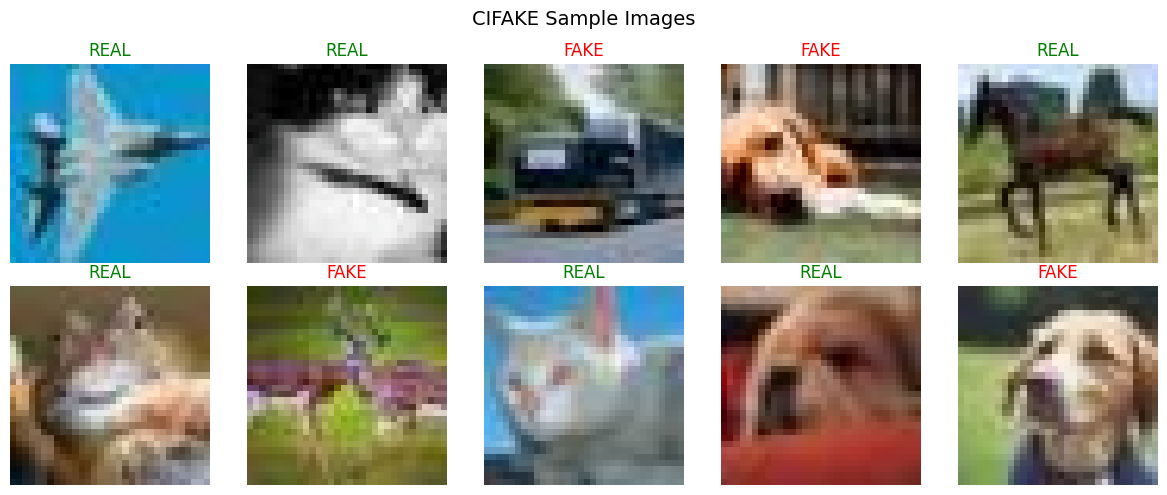

In [16]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(tensor.device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(tensor.device)
    return (tensor * std + mean).clamp(0, 1)

# Plot sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('CIFAKE Sample Images', fontsize=14)

for i, ax in enumerate(axes.flatten()):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    label = train_dataset.classes[labels[i]]
    ax.imshow(img)
    ax.set_title(label, color='green' if label == 'REAL' else 'red')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import Subset, DataLoader
import random, numpy as np, copy
from torch.backends import cudnn
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, RocCurveDisplay,
                             precision_recall_curve, average_precision_score, PrecisionRecallDisplay)

# Reproducibility
seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
cudnn.deterministic = True
cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# 1. Load Pretrained ResNet-50
num_classes = 2 # FAKE and REAL
model_resnet = models.resnet50(weights='IMAGENET1K_V1')

# 2. Fine-tuning strategy: Freeze all but layer4 and fc
for name, param in model_resnet.named_parameters():
    if not (name.startswith('layer4') or name.startswith('fc')):
        param.requires_grad = False

# 3. Replace final layer
in_feats = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_feats, num_classes)
model_resnet = model_resnet.to(device)

# 4. Define Training Function (Named correctly to match your call)
def train_resnet(model, train_loader, val_loader, epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=1e-3, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(epochs):
        model.train()
        run_loss, preds, labels = 0.0, [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * x.size(0)
            preds.extend(out.argmax(1).cpu().tolist())
            labels.extend(y.cpu().tolist())

        # Validation phase
        model.eval()
        v_preds, v_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                v_preds.extend(out.argmax(1).cpu().tolist())
                v_labels.extend(y.cpu().tolist())

        val_acc = accuracy_score(v_labels, v_preds)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "best_resnet_cifake.pth")

    model.load_state_dict(best_model_wts)
    return model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [19]:
print("Starting Resnet...")
model_resnet = train_resnet(model_resnet, train_loader, val_loader, epochs=5)

Starting Resnet...
Epoch 1/5 | Val Acc: 0.9197
Epoch 2/5 | Val Acc: 0.9326
Epoch 3/5 | Val Acc: 0.9385
Epoch 4/5 | Val Acc: 0.9357
Epoch 5/5 | Val Acc: 0.9397


Evaluating ResNet-50 on test data...

--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        FAKE       0.94      0.94      0.94     10000
        REAL       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



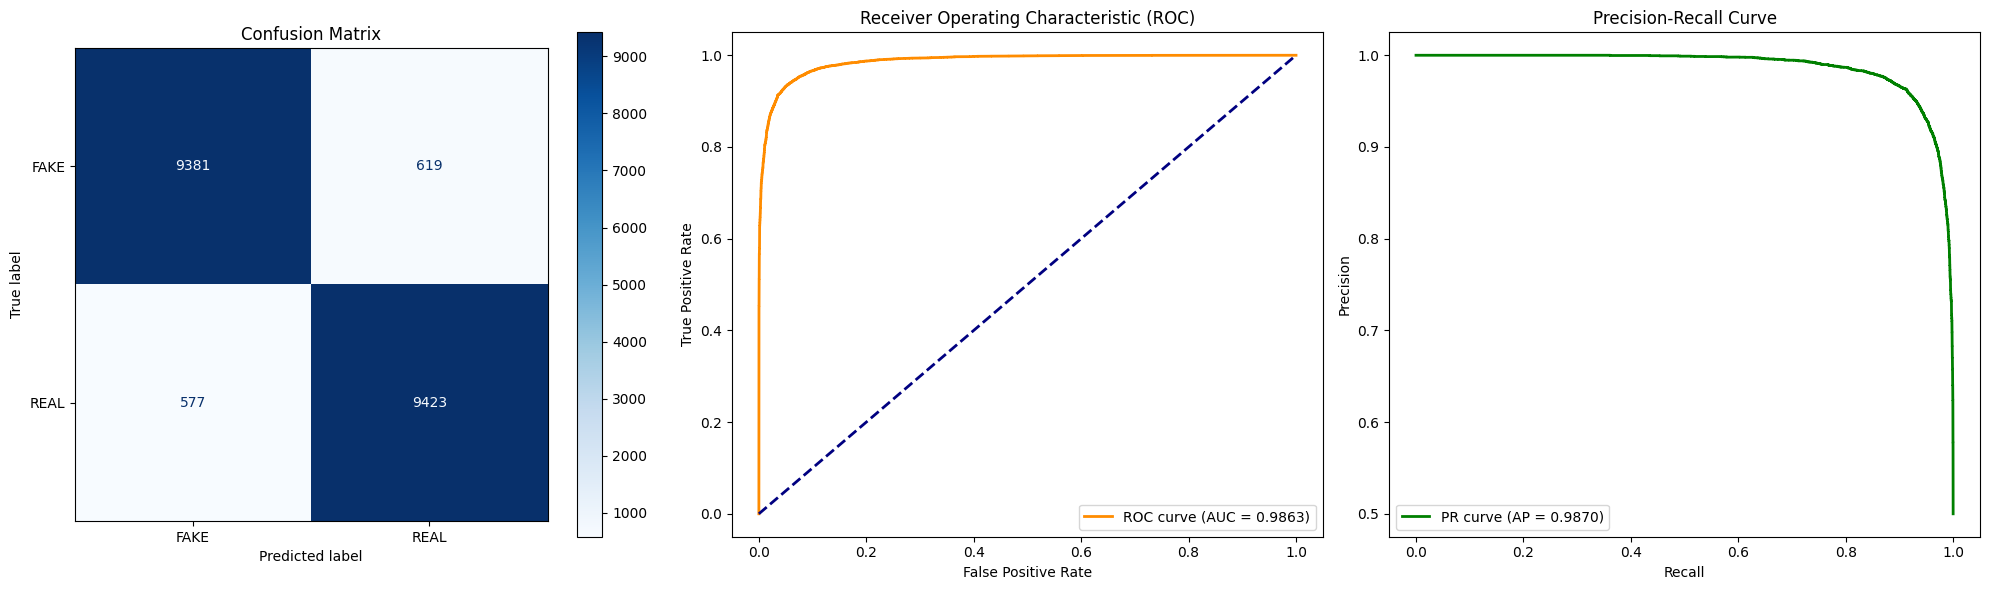

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

# 1. Generate Predictions for the Test Set
model_resnet.eval()
all_preds = []
all_labels = []
all_probs = []

print("Evaluating ResNet-50 on test data...")
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model_resnet(x)

        # Get probabilities for the 'REAL' class (index 1)
        probs = torch.softmax(outputs, dim=1)

        all_probs.extend(probs[:, 1].cpu().numpy())
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 2. Print Classification Metrics
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(all_labels, all_preds, target_names=["FAKE", "REAL"]))

# 3. Plot Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE", "REAL"])
disp.plot(cmap='Blues', ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix')

# 4. Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC)')
ax[1].legend(loc="lower right")

# 5. Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
ap_score = average_precision_score(all_labels, all_probs)
ax[2].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {ap_score:.4f})')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Precision-Recall Curve')
ax[2].legend(loc="lower left")

plt.tight_layout()
plt.show()

In [21]:
# SAVING THE MODEL

# 1. Define the filename
MODEL_NAME = "cifake_resnet50_baseline1.pth"

# 2. Save the state_dict (Weights)
# We save the model's 'state_dict' which is the industry standard
torch.save(model_resnet.state_dict(), MODEL_NAME)

print(f"✅ Model weights saved as: {MODEL_NAME}")




✅ Model weights saved as: cifake_resnet50_baseline1.pth


In [22]:
import torch
import torch.nn as nn
import copy
from torchvision import models

# Must recreate the exact same architecture used during training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2

model_resnet = models.resnet50(weights='IMAGENET1K_V1')

# Freeze layers (same as training)
for name, param in model_resnet.named_parameters():
    if not (name.startswith('layer4') or name.startswith('fc')):
        param.requires_grad = False

# Replace final layer (same as training)
in_feats = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_feats, num_classes)

# Load saved weights
model_resnet.load_state_dict(torch.load('cifake_resnet50_baseline1.pth', map_location=device))
model_resnet = model_resnet.to(device)
model_resnet.eval()  # Very important!

print("ResNet-50 loaded successfully!")

ResNet-50 loaded successfully!


In [23]:
from torchvision import transforms
from PIL import Image

# ResNet expects 224x224 — NOT 32x32!
transform = transforms.Compose([
    transforms.Resize((32,32)),         # ResNet standard input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet stats
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image)
    tensor = tensor.unsqueeze(0)           # (1, 3, 224, 224)
    return tensor

In [24]:
def predict(image_path, model, device, threshold=0.5):
    # Must match your dataset's class_to_idx order
    # ImageFolder loads alphabetically: FAKE=0, REAL=1
    class_names = {0: 'FAKE', 1: 'REAL'}

    image_tensor = preprocess_image(image_path).to(device)

    with torch.no_grad():
        output      = model(image_tensor)          # Raw logits (1, 2)
        probs       = torch.softmax(output, dim=1) # Convert to probabilities
        confidence, predicted_class = torch.max(probs, dim=1)

    label      = class_names[predicted_class.item()]
    confidence = confidence.item()

    print(f"Image          : {image_path}")
    print(f"Prediction     : {label}")
    print(f"Confidence     : {confidence*100:.2f}%")
    print(f"  → FAKE : {probs[0][0].item()*100:.2f}%")
    print(f"  → REAL : {probs[0][1].item()*100:.2f}%")

    return label, confidence

# Run it
label, confidence = predict('/content/cifake/test/FAKE/0.jpg', model_resnet, device)

Image          : /content/cifake/test/FAKE/0.jpg
Prediction     : FAKE
Confidence     : 99.55%
  → FAKE : 99.55%
  → REAL : 0.45%


In [25]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=16d75c9e4ea68d6dc139b94a3fd162194955307ed00085a5919e0f5bdd29e1bc
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [26]:
!pip install "grad-cam>=1.3.6"

In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import models, transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [28]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image).unsqueeze(0)  # (1, 3, 224, 224)
    return image, tensor

In [29]:
def compute_saliency_map(model, image_tensor, device):
    """
    Saliency map: gradient of the predicted class score
    with respect to the input image pixels.
    The higher the gradient, the more that pixel
    influenced the prediction.
    """
    model.eval()
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad_()  # Enable gradient on input

    output = model(image_tensor)
    probs  = torch.softmax(output, dim=1)
    pred_class = probs.argmax(dim=1).item()

    # Backprop the score of predicted class
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # Take max across color channels
    saliency = image_tensor.grad.data.abs()
    saliency, _ = torch.max(saliency, dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    return saliency, pred_class, probs

In [30]:
def compute_gradcam(model, image_tensor, device):
    """
    Grad-CAM: uses gradients flowing into the last
    convolutional layer to produce a coarse localization
    map highlighting important regions.
    """
    # Target the last conv layer of ResNet-50
    target_layers = [model.layer4[-1]]

    image_tensor = image_tensor.to(device)

    with GradCAM(model=model, target_layers=target_layers) as cam:
        probs        = torch.softmax(model(image_tensor), dim=1)
        pred_class   = probs.argmax(dim=1).item()

        targets      = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0]  # Remove batch dim

    return grayscale_cam, pred_class, probs

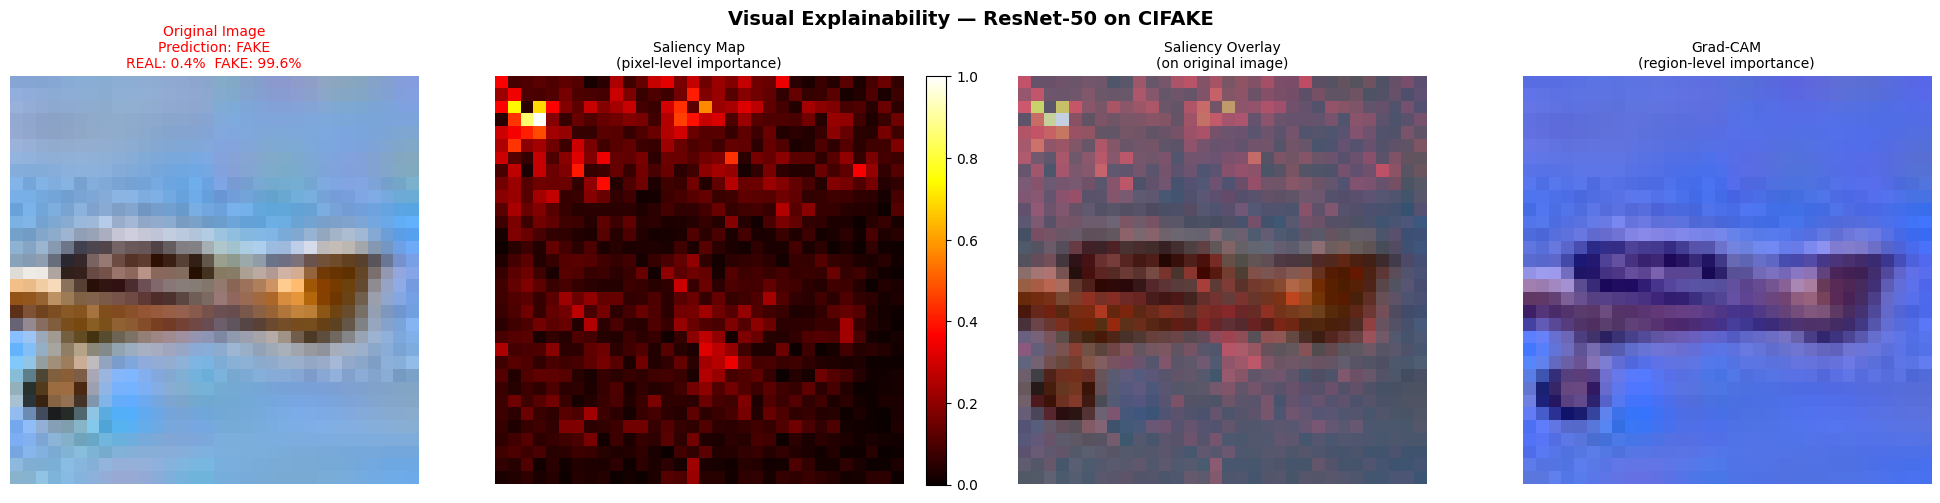


Prediction : FAKE
REAL       : 0.45%
FAKE       : 99.55%


In [31]:
def visualize_explainability(image_path, model, device):
    class_names = {0: 'FAKE', 1: 'REAL'}
    colors      = {0: 'red',  1: 'green'}

    # Load image
    original_image, image_tensor = load_image(image_path)
    original_np = np.array(original_image.resize((32,32))) / 255.0  # Normalize to [0,1]

    # ---- Saliency Map ----
    saliency, sal_pred, sal_probs = compute_saliency_map(model,
                                                          image_tensor.clone(),
                                                          device)

    # ---- Grad-CAM ----
    gradcam, cam_pred, cam_probs = compute_gradcam(model,
                                                    image_tensor.clone(),
                                                    device)

    # Overlay Grad-CAM on original image
    gradcam_overlay = show_cam_on_image(original_np.astype(np.float32),
                                        gradcam,
                                        use_rgb=True)

    # ---- Plot ----
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Visual Explainability — ResNet-50 on CIFAKE",
                 fontsize=14, fontweight='bold')

    # 1. Original Image
    axes[0].imshow(original_np)
    pred_label = class_names[cam_pred]
    pred_color = colors[cam_pred]
    axes[0].set_title(f"Original Image\nPrediction: {pred_label}\n"
                      f"REAL: {cam_probs[0][1].item()*100:.1f}%  "
                      f"FAKE: {cam_probs[0][0].item()*100:.1f}%",
                      color=pred_color, fontsize=10)
    axes[0].axis('off')

    # 2. Saliency Map
    axes[1].imshow(saliency, cmap='hot')
    axes[1].set_title("Saliency Map\n(pixel-level importance)", fontsize=10)
    axes[1].axis('off')
    plt.colorbar(cm.ScalarMappable(cmap='hot'), ax=axes[1], fraction=0.046)

    # 3. Saliency Overlay
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    saliency_colored = plt.cm.hot(saliency_norm)[:, :, :3]
    overlay = (0.5 * original_np + 0.5 * saliency_colored)
    overlay = np.clip(overlay, 0, 1)
    axes[2].imshow(overlay)
    axes[2].set_title("Saliency Overlay\n(on original image)", fontsize=10)
    axes[2].axis('off')

    # 4. Grad-CAM Overlay
    axes[3].imshow(gradcam_overlay)
    axes[3].set_title("Grad-CAM\n(region-level importance)", fontsize=10)
    axes[3].axis('off')

    plt.tight_layout()
    plt.savefig('explainability_output.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nPrediction : {pred_label}")
    print(f"REAL       : {cam_probs[0][1].item()*100:.2f}%")
    print(f"FAKE       : {cam_probs[0][0].item()*100:.2f}%")

# Run it
visualize_explainability('/content/cifake/test/FAKE/0.jpg', model_resnet, device)

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

# 1. Generate Predictions for the Test Set
model_resnet.eval()
all_preds  = []
all_labels = []
all_probs  = []

# ---- NEW: Store high confidence FAKE images ----
high_conf_fake_images  = []   # Stores original images
high_conf_fake_probs   = []   # Stores FAKE confidence score
high_conf_fake_labels  = []   # Stores true label (to check if actually fake)

CONFIDENCE_THRESHOLD = 0.90   # 90% confidence

print("Evaluating ResNet-50 on test data...")

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model_resnet(x)
        probs   = torch.softmax(outputs, dim=1)

        fake_probs = probs[:, 0]   # FAKE class probability (index 0)
        real_probs = probs[:, 1]   # REAL class probability (index 1)
        preds      = outputs.argmax(1)

        all_probs.extend(real_probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

        # ---- Collect high confidence FAKE predictions ----
        for i in range(len(x)):
            pred      = preds[i].item()
            fake_conf = fake_probs[i].item()
            true_label = y[i].item()

            # Predicted FAKE and confidence > 90%
            if pred == 0 and fake_conf >= CONFIDENCE_THRESHOLD:
                # Denormalize image for display
                img_tensor = x[i].cpu()
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
                std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
                img_denorm = (img_tensor * std + mean).clamp(0, 1)
                img_np = img_denorm.permute(1, 2, 0).numpy()

                high_conf_fake_images.append(img_np)
                high_conf_fake_probs.append(fake_conf)
                high_conf_fake_labels.append(true_label)

print(f"\nTotal high confidence FAKE images (>90%): {len(high_conf_fake_images)}")

Evaluating ResNet-50 on test data...

Total high confidence FAKE images (>90%): 8321


Phase 2 - STARTING HERE


In [33]:
import cv2
import torch.nn.functional as F

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

ATTACK 1

GAUSSIAN BLUR ATTACK WITH KERNEL SIZE 3X3

In [35]:
def predict_image(model, image_np):
    """
    image_np: numpy image in range [0,255], shape (H,W,3)
    """
    model.eval()

    # Convert to PIL
    image_pil = Image.fromarray(image_np.astype(np.uint8))

    # Apply transform
    input_tensor = transform(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)

    confidence_fake = probs[0][0].item()
    confidence_real = probs[0][1].item()
    predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class, confidence_real, confidence_fake

In [36]:
def gaussian_blur_attack(image_np, kernel_size=3):
    """
    Applies mild Gaussian blur.

    kernel_size: must be odd (3, 5, 7)
    """
    blurred = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), 0)
    return blurred

In [37]:
def run_blur_evasion(model, image_np, kernel_size=3):

    # # Original Prediction
    # pred_orig, real_orig, fake_orig = predict_image(model, image_np)

    # print("=== ORIGINAL IMAGE ===")
    # print(f"Predicted: {'FAKE' if pred_orig == 1 else 'REAL'}")
    # print(f"Confidence REAL: {real_orig:.4f}")
    # print(f"Confidence FAKE: {fake_orig:.4f}")

    # Apply Gaussian Blur
    blurred_image = gaussian_blur_attack(image_np, kernel_size)

    # Blurred Prediction
    pred_blur, real_blur, fake_blur = predict_image(model, blurred_image)

    print("\n=== AFTER GAUSSIAN BLUR ===")
    print(f"Predicted: {'FAKE' if pred_blur == 0 else 'REAL'}")
    print(f"Confidence REAL: {real_blur:.4f}")
    print(f"Confidence FAKE: {fake_blur:.4f}")

    # Visual Comparison
    fig, axes = plt.subplots(1, 2, figsize=(8,4))

    axes[0].imshow(image_np)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(blurred_image)
    axes[1].set_title(f"Blurred (k={kernel_size})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    return blurred_image

Before Gaussian Blur....
Image          : /content/cifake/test/FAKE/997.jpg
Prediction     : FAKE
Confidence     : 99.63%
  → FAKE : 99.63%
  → REAL : 0.37%

=== AFTER GAUSSIAN BLUR ===
Predicted: FAKE
Confidence REAL: 0.1531
Confidence FAKE: 0.8469


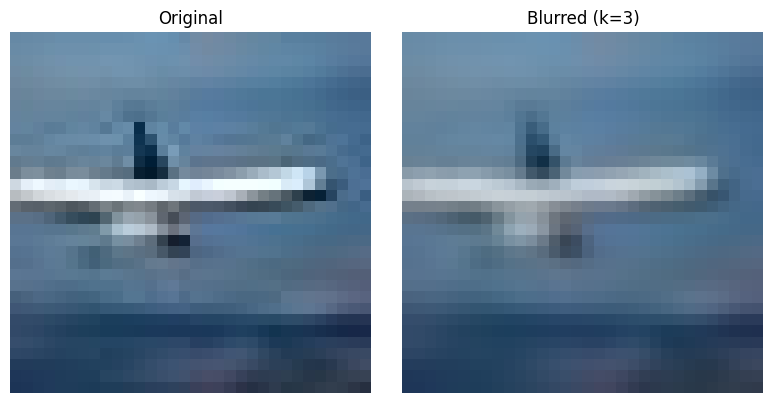

In [59]:
from PIL import Image
image=Image.open("/content/cifake/test/FAKE/997.jpg").convert("RGB")
image_np=np.array(image)
print("Before Gaussian Blur....")
label, confidence = predict('/content/cifake/test/FAKE/997.jpg', model_resnet, device)
blurred_img = run_blur_evasion(model_resnet, image_np, kernel_size=3)

ATTACK 2

JPEG COMPRESSION

In [39]:
import cv2
import numpy as np

def jpeg_compression_attack(image_np, quality=50):
    """
    Simulates JPEG compression.

    image_np: numpy array (H,W,3), RGB, uint8 [0-255]
    quality: 1–100 (lower = stronger compression)
    """

    if image_np is None:
        raise ValueError("image_np is None")

    # Convert RGB → BGR for OpenCV
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Encode with compression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encimg = cv2.imencode('.jpg', image_bgr, encode_param)

    if not result:
        raise ValueError("JPEG encoding failed")

    # Decode back to image
    compressed_bgr = cv2.imdecode(encimg, 1)

    # Convert back BGR → RGB
    compressed_rgb = cv2.cvtColor(compressed_bgr, cv2.COLOR_BGR2RGB)

    return compressed_rgb

In [40]:
import matplotlib.pyplot as plt

def run_jpeg_evasion(model, image_np, quality=50):
    # APPLY JPEG
    compressed_img = jpeg_compression_attack(image_np, quality)

    pred_comp, real_comp, fake_comp = predict_image(model, compressed_img)

    print("\n=== AFTER JPEG COMPRESSION ===")
    print(f"JPEG Quality: {quality}")
    print(f"Predicted: {'FAKE' if pred_comp == 0 else 'REAL'}")
    print(f"Confidence FAKE: {fake_comp:.4f}")
    print(f"Confidence REAL: {real_comp:.4f}")

    # Visual Comparison
    fig, axes = plt.subplots(1, 2, figsize=(8,4))

    axes[0].imshow(image_np)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(compressed_img)
    axes[1].set_title(f"JPEG (Q={quality})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
    return compressed_img

Before jpeg compression
Image          : /content/download1.jpg
Prediction     : REAL
Confidence     : 81.93%
  → FAKE : 18.07%
  → REAL : 81.93%

=== AFTER JPEG COMPRESSION ===
JPEG Quality: 50
Predicted: REAL
Confidence FAKE: 0.0646
Confidence REAL: 0.9354


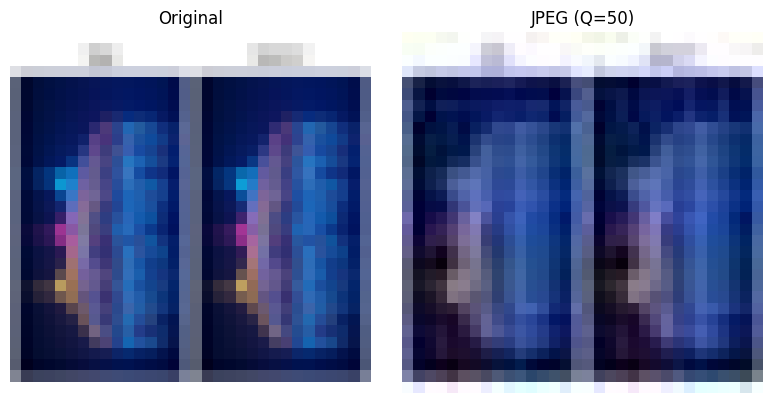

array([[[254, 255, 241],
        [252, 255, 241],
        [252, 255, 242],
        ...,
        [255, 255, 248],
        [255, 255, 248],
        [255, 255, 246]],

       [[248, 254, 244],
        [247, 253, 243],
        [252, 255, 251],
        ...,
        [249, 247, 248],
        [247, 245, 246],
        [238, 237, 235]],

       [[251, 255, 255],
        [244, 249, 255],
        [251, 255, 255],
        ...,
        [254, 253, 255],
        [254, 253, 255],
        [254, 253, 255]],

       ...,

       [[ 87,  90, 133],
        [  3,   2,  42],
        [  3,   0,  30],
        ...,
        [  0,   6,  42],
        [  1,  12,  40],
        [ 71,  82, 104]],

       [[126, 130, 167],
        [ 66,  66, 100],
        [ 78,  72, 100],
        ...,
        [ 59,  79, 103],
        [ 60,  74,  87],
        [121, 131, 140]],

       [[248, 252, 255],
        [231, 232, 255],
        [255, 251, 255],
        ...,
        [237, 255, 255],
        [215, 230, 237],
        [247, 255, 255]]], dtype=uint8)
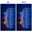

In [58]:
from PIL import Image
import numpy as np

image = Image.open("/content/cifake/test/FAKE/0.jpg").convert("RGB")
image = image.resize((32,32))  # CIFAKE size
image_np = np.array(image)
print('Before jpeg compression')
label, confidence = predict('/content/cifake/test/FAKE/0.jpg', model_resnet, device)
run_jpeg_evasion(model_resnet, image_np, quality=50)


In [43]:
# PIXEL LEVEL PERTURBATION - Random Noise Attack (Baseline)
import torchvision.transforms as transforms
from PIL import Image
import os

def random_noise_attack_tensor(image_tensor, epsilon=0.01):
    noise = torch.randn_like(image_tensor) * epsilon
    adv_image = image_tensor + noise
    return torch.clamp(adv_image, -1, 1)

def test_random_noise_with_predict(image_path, model, device, epsilon=0.01):

    print("========== ORIGINAL IMAGE ==========")
    label_before, conf_before = predict(image_path, model, device)

    # Load and preprocess same way as predict()
    image_tensor = preprocess_image(image_path).to(device)

    # Remove batch dimension if exists
    if image_tensor.dim() == 4:
        image_tensor = image_tensor.squeeze(0)

    # Apply noise
    adv_tensor = random_noise_attack_tensor(image_tensor, epsilon)

    # Convert tensor back to PIL to save temporarily
    to_pil = transforms.ToPILImage()

    # IMPORTANT: If your image was normalized, you must UNNORMALIZE before saving
    # (Adjust mean/std if different)
    mean = torch.tensor([0.5,0.5,0.5]).view(3,1,1).to(device)
    std  = torch.tensor([0.3,0.3,0.3]).view(3,1,1).to(device)
    adv_tensor_unnorm = adv_tensor * std + mean
    adv_tensor_unnorm = torch.clamp(adv_tensor_unnorm, 0, 1)

    adv_image_pil = to_pil(adv_tensor_unnorm.cpu())

    noisy_path = "temp_noisy_image.jpg"
    adv_image_pil.save(noisy_path)

    print("\n========== AFTER RANDOM NOISE ==========")
    label_after, conf_after = predict(noisy_path, model, device)

    if label_before != label_after:
        print("\n🚨 Prediction FLIPPED due to random noise!")
    else:
        print("\n✅ Prediction unchanged.")

    print(f"\nConfidence Change: {conf_before*100:.2f}% → {conf_after*100:.2f}%")

    return noisy_path

test_random_noise_with_predict('/content/cifake/test/FAKE/0.jpg', model_resnet, device, epsilon=0.2)

========== ORIGINAL IMAGE ==========
Image          : /content/cifake/test/FAKE/0.jpg
Prediction     : FAKE
Confidence     : 99.55%
  → FAKE : 99.55%
  → REAL : 0.45%

========== AFTER RANDOM NOISE ==========
Image          : temp_noisy_image.jpg
Prediction     : REAL
Confidence     : 98.21%
  → FAKE : 1.79%
  → REAL : 98.21%

🚨 Prediction FLIPPED due to random noise!

Confidence Change: 99.55% → 98.21%


'temp_noisy_image.jpg'

In [44]:
# PIXEL LEVEL PERTURBATION - FGSM Attack
import torch
import torchvision.transforms as transforms
from PIL import Image

def fgsm_attack_tensor(model, image_tensor, label, epsilon, device):
    model.eval()

    image = image_tensor.clone().detach().to(device)
    image.requires_grad = True

    label_tensor = torch.tensor([label]).to(device)

    output = model(image.unsqueeze(0))
    loss = torch.nn.CrossEntropyLoss()(output, label_tensor)

    model.zero_grad()
    loss.backward()

    gradient = image.grad.data
    perturbed = image + epsilon * gradient.sign()

    return torch.clamp(perturbed, -1, 1).detach()

def test_fgsm_with_predict(image_path, model, device, epsilon=0.01):

    print("========== ORIGINAL IMAGE ==========")
    label_before, conf_before = predict(image_path, model, device)

    # Convert label to numeric
    label_numeric = 0 if label_before == "FAKE" else 1

    # Load and preprocess
    image_tensor = preprocess_image(image_path).to(device)

    if image_tensor.dim() == 4:
        image_tensor = image_tensor.squeeze(0)

    # Apply FGSM
    adv_tensor = fgsm_attack_tensor(
        model,
        image_tensor,
        label_numeric,
        epsilon,
        device
    )

    # Unnormalize before saving
    mean = torch.tensor([0.5,0.5,0.5]).view(3,1,1).to(device)
    std  = torch.tensor([0.3,0.3,0.3]).view(3,1,1).to(device)

    adv_tensor_unnorm = adv_tensor * std + mean
    adv_tensor_unnorm = torch.clamp(adv_tensor_unnorm, 0, 1)

    to_pil = transforms.ToPILImage()
    adv_image_pil = to_pil(adv_tensor_unnorm.cpu())

    adv_path = "temp_fgsm_image.jpg"
    adv_image_pil.save(adv_path)

    print("\n========== AFTER FGSM ATTACK ==========")
    label_after, conf_after = predict(adv_path, model, device)

    if label_before != label_after:
        print("\n🚨 Prediction FLIPPED due to FGSM attack!")
    else:
        print("\n⚠️ Prediction unchanged.")

    print(f"\nConfidence Change: {conf_before*100:.2f}% → {conf_after*100:.2f}%")

    return adv_path

test_fgsm_with_predict('/content/cifake/test/FAKE/0.jpg',model_resnet,  device, epsilon=0.21)

========== ORIGINAL IMAGE ==========
Image          : /content/cifake/test/FAKE/0.jpg
Prediction     : FAKE
Confidence     : 99.55%
  → FAKE : 99.55%
  → REAL : 0.45%

========== AFTER FGSM ATTACK ==========
Image          : temp_fgsm_image.jpg
Prediction     : REAL
Confidence     : 97.88%
  → FAKE : 2.12%
  → REAL : 97.88%

🚨 Prediction FLIPPED due to FGSM attack!

Confidence Change: 99.55% → 97.88%


'temp_fgsm_image.jpg'

In [45]:
# PIXEL LEVEL PERTURBATION - BIM (Iterative FGSM) Attack
def bim_attack_tensor(model, image_tensor, label, epsilon, alpha, steps, device):
    model.eval()

    original = image_tensor.clone().detach().to(device)
    perturbed = original.clone().detach()

    label_tensor = torch.tensor([label]).to(device)

    for _ in range(steps):
        perturbed.requires_grad = True

        output = model(perturbed.unsqueeze(0))
        loss = torch.nn.CrossEntropyLoss()(output, label_tensor)

        model.zero_grad()
        loss.backward()

        gradient = perturbed.grad.data
        perturbed = perturbed + alpha * gradient.sign()

        # Project back to epsilon-ball
        delta = torch.clamp(perturbed - original, -epsilon, epsilon)
        perturbed = torch.clamp(original + delta, -1, 1).detach()

    return perturbed

def test_bim_with_predict(image_path, model, device, epsilon=0.02, alpha=0.005, steps=5):

    print("========== ORIGINAL IMAGE ==========")
    label_before, conf_before = predict(image_path, model, device)

    label_numeric = 0 if label_before == "FAKE" else 1

    image_tensor = preprocess_image(image_path).to(device)
    if image_tensor.dim() == 4:
        image_tensor = image_tensor.squeeze(0)

    adv_tensor = bim_attack_tensor(
        model,
        image_tensor,
        label_numeric,
        epsilon,
        alpha,
        steps,
        device
    )

    # Unnormalize
    mean = torch.tensor([0.5,0.5,0.5]).view(3,1,1).to(device)
    std  = torch.tensor([0.3,0.3,0.3]).view(3,1,1).to(device)

    adv_tensor_unnorm = adv_tensor * std + mean
    adv_tensor_unnorm = torch.clamp(adv_tensor_unnorm, 0, 1)

    adv_path = "temp_bim_image.jpg"
    transforms.ToPILImage()(adv_tensor_unnorm.cpu()).save(adv_path)

    print("\n========== AFTER BIM ATTACK ==========")
    label_after, conf_after = predict(adv_path, model, device)

    if label_before != label_after:
        print("\n🚨 Prediction FLIPPED due to BIM attack!")
    else:
        print("\n⚠️ Prediction unchanged.")

    print(f"\nConfidence Change: {conf_before*100:.2f}% → {conf_after*100:.2f}%")

    return adv_path

test_bim_with_predict('/content/cifake/test/FAKE/0.jpg', model_resnet, device, epsilon=0.5, alpha=0.01, steps=10)

========== ORIGINAL IMAGE ==========
Image          : /content/cifake/test/FAKE/0.jpg
Prediction     : FAKE
Confidence     : 99.55%
  → FAKE : 99.55%
  → REAL : 0.45%

========== AFTER BIM ATTACK ==========
Image          : temp_bim_image.jpg
Prediction     : REAL
Confidence     : 99.97%
  → FAKE : 0.03%
  → REAL : 99.97%

🚨 Prediction FLIPPED due to BIM attack!

Confidence Change: 99.55% → 99.97%


'temp_bim_image.jpg'

In [46]:
# PIXEL LEVEL PERTURBATION - PGD (Strongest First-Order Attack)
def pgd_attack_tensor(model, image_tensor, label, epsilon, alpha, steps, device):
    model.eval()

    original = image_tensor.clone().detach().to(device)
    label_tensor = torch.tensor([label]).to(device)

    # Random start
    perturbed = original + torch.empty_like(original).uniform_(-epsilon, epsilon)
    perturbed = torch.clamp(perturbed, -1, 1)

    for _ in range(steps):
        perturbed.requires_grad = True

        output = model(perturbed.unsqueeze(0))
        loss = torch.nn.CrossEntropyLoss()(output, label_tensor)

        model.zero_grad()
        loss.backward()

        gradient = perturbed.grad.data
        perturbed = perturbed + alpha * gradient.sign()

        delta = torch.clamp(perturbed - original, -epsilon, epsilon)
        perturbed = torch.clamp(original + delta, -1, 1).detach()

    return perturbed

def test_pgd_with_predict(image_path, model, device, epsilon=0.02, alpha=0.005, steps=7):

    print("========== ORIGINAL IMAGE ==========")
    label_before, conf_before = predict(image_path, model, device)

    label_numeric = 0 if label_before == "FAKE" else 1

    image_tensor = preprocess_image(image_path).to(device)
    if image_tensor.dim() == 4:
        image_tensor = image_tensor.squeeze(0)

    adv_tensor = pgd_attack_tensor(
        model,
        image_tensor,
        label_numeric,
        epsilon,
        alpha,
        steps,
        device
    )

    # Unnormalize
    mean = torch.tensor([0.5,0.5,0.5]).view(3,1,1).to(device)
    std  = torch.tensor([0.3,0.3,0.3]).view(3,1,1).to(device)

    adv_tensor_unnorm = adv_tensor * std + mean
    adv_tensor_unnorm = torch.clamp(adv_tensor_unnorm, 0, 1)

    adv_path = "temp_pgd_image.jpg"
    transforms.ToPILImage()(adv_tensor_unnorm.cpu()).save(adv_path)

    print("\n========== AFTER PGD ATTACK ==========")
    label_after, conf_after = predict(adv_path, model, device)

    if label_before != label_after:
        print("\n🚨 Prediction FLIPPED due to PGD attack!")
    else:
        print("\n⚠️ Prediction unchanged.")

    print(f"\nConfidence Change: {conf_before*100:.2f}% → {conf_after*100:.2f}%")

    return adv_path

test_pgd_with_predict('/content/cifake/test/FAKE/0.jpg', model_resnet, device, epsilon=0.3, alpha=0.01, steps=15)

========== ORIGINAL IMAGE ==========
Image          : /content/cifake/test/FAKE/0.jpg
Prediction     : FAKE
Confidence     : 99.55%
  → FAKE : 99.55%
  → REAL : 0.45%

========== AFTER PGD ATTACK ==========
Image          : temp_pgd_image.jpg
Prediction     : REAL
Confidence     : 99.76%
  → FAKE : 0.24%
  → REAL : 99.76%

🚨 Prediction FLIPPED due to PGD attack!

Confidence Change: 99.55% → 99.76%


'temp_pgd_image.jpg'

ORIGINAL IMAGE
Image       : /content/cifake/test/FAKE/0.jpg
Prediction  : FAKE
Confidence  : 99.55%
  → FAKE : 99.55%
  → REAL : 0.45%

Searching for evasion threshold...

======= AFTER FREQUENCY (FFT) ATTACK =======
Final Keep Fraction used: 0.15
Image       : temp_fft_image.jpg
Prediction  : REAL
Confidence  : 94.17%
  → FAKE : 5.83%
  → REAL : 94.17%

Prediction FLIPPED due to Frequency attack!
Confidence Change: 99.55% → 94.17%


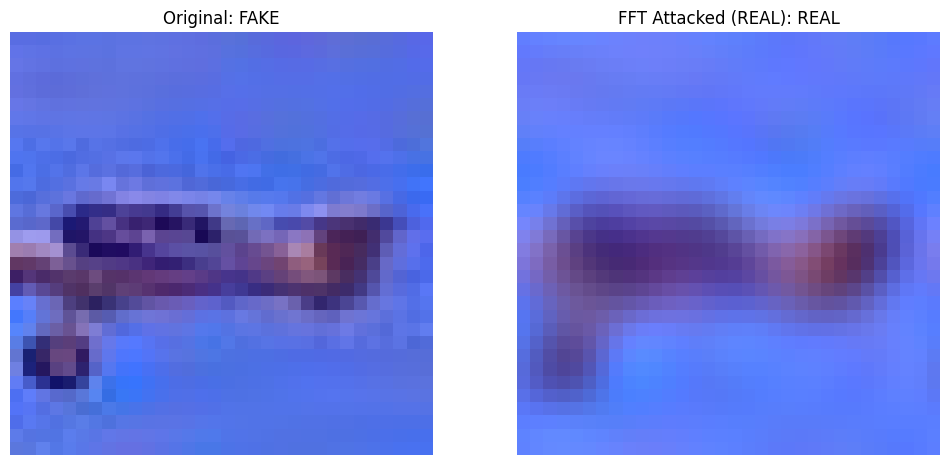

In [47]:
#Frequency domain attack
import torch.fft as fft
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image

# ---FFT ATTACK FUNCTION ---
def apply_frequency_attack(image_tensor, keep_fraction=0.15):
    """Surgically removes high-frequency AI fingerprints."""
    image_fft = fft.fft2(image_tensor)
    image_fft_shifted = fft.fftshift(image_fft)

    C, H, W = image_tensor.shape
    mask = torch.zeros_like(image_fft_shifted)
    h_keep, w_keep = int(H * keep_fraction), int(W * keep_fraction)
    center_h, center_w = H // 2, W // 2

    mask[:, center_h - h_keep : center_h + h_keep, center_w - w_keep : center_w + w_keep] = 1

    filtered_fft = image_fft_shifted * mask
    filtered_fft = fft.ifftshift(filtered_fft)
    return fft.ifft2(filtered_fft).real.clamp(-2, 2)

def run_frequency_task_on_file(image_path, model, start_fraction=0.15):
    model.eval()
    class_names = {0: 'FAKE', 1: 'REAL'}

    # Load and Preprocess
    orig_img_pil = Image.open(image_path).convert('RGB')
    input_tensor = transform(orig_img_pil).unsqueeze(0).to(device)

    # --- ORIGINAL PREDICTION ---
    with torch.no_grad():
        out_orig = model(input_tensor)
        probs_orig = torch.softmax(out_orig, dim=1)[0]
        conf_orig, pred_idx_orig = torch.max(probs_orig, dim=0)

    label_orig = class_names[pred_idx_orig.item()]
    cam_orig, _, _ = compute_gradcam(model, input_tensor, device)

    print("ORIGINAL IMAGE")
    print(f"Image       : {image_path}")
    print(f"Prediction  : {label_orig}")
    print(f"Confidence  : {conf_orig.item()*100:.2f}%")
    print(f"  → FAKE : {probs_orig[0].item()*100:.2f}%")
    print(f"  → REAL : {probs_orig[1].item()*100:.2f}%")

    # --- FREQUENCY ATTACK (AUTO-SEARCH FOR FLIP) ---
    # We will decrease keep_fraction until label_attack becomes 'REAL'
    current_frac = start_fraction
    label_attack = label_orig

    print(f"\nSearching for evasion threshold...")

    while label_attack == label_orig and current_frac > 0.02:
        attacked_tensor = apply_frequency_attack(input_tensor.squeeze(0), current_frac).unsqueeze(0).to(device)

        with torch.no_grad():
            out_attack = model(attacked_tensor)
            probs_attack = torch.softmax(out_attack, dim=1)[0]
            conf_attack, pred_idx_attack = torch.max(probs_attack, dim=0)
            label_attack = class_names[pred_idx_attack.item()]

        if label_attack == label_orig:
            current_frac -= 0.02 # Make the filter more aggressive

    # Save temp image of the SUCCESSFUL attack
    attacked_np = denormalize(attacked_tensor.squeeze(0)).permute(1, 2, 0).cpu().numpy()
    attacked_np = (np.clip(attacked_np, 0, 1) * 255).astype(np.uint8)
    temp_path = "temp_fft_image.jpg"
    Image.fromarray(attacked_np).save(temp_path)

    cam_attack, _, _ = compute_gradcam(model, attacked_tensor, device)

    print(f"\n======= AFTER FREQUENCY (FFT) ATTACK =======")
    print(f"Final Keep Fraction used: {current_frac:.2f}")
    print(f"Image       : {temp_path}")
    print(f"Prediction  : {label_attack}")
    print(f"Confidence  : {conf_attack.item()*100:.2f}%")
    print(f"  → FAKE : {probs_attack[0].item()*100:.2f}%")
    print(f"  → REAL : {probs_attack[1].item()*100:.2f}%")

    if label_orig != label_attack:
        print(f"\nPrediction FLIPPED due to Frequency attack!")
        print(f"Confidence Change: {conf_orig.item()*100:.2f}% → {conf_attack.item()*100:.2f}%")
    else:
        print(f"\nPrediction did not flip (Model is extremely robust).")

    # --- GRAD-CAM VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    img_orig_np = denormalize(input_tensor.squeeze(0)).permute(1, 2, 0).cpu().numpy()
    axes[0].imshow(show_cam_on_image(img_orig_np.astype(np.float32), cam_orig, use_rgb=True))
    axes[0].set_title(f"Original: {label_orig}")
    axes[0].axis('off')

    axes[1].imshow(show_cam_on_image(np.clip(attacked_np/255.0, 0, 1).astype(np.float32), cam_attack, use_rgb=True))
    axes[1].set_title(f"FFT Attacked (REAL): {label_attack}")
    axes[1].axis('off')

    plt.show()

# Run it
my_image_path = '/content/cifake/test/FAKE/0.jpg'
run_frequency_task_on_file(my_image_path, model_resnet, start_fraction=0.15)

In [49]:
import torch.optim as optim
import random
import copy

def unified_mitigation_training(model, train_loader, device, epochs=3):
    print("Starting Unified Multi-Attack Mitigation (Spectral + Spatial Hardening)...")
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Select an attack to "defend" against in this batch
            # 0: Clean, 1: FFT, 2: Noise/PGD, 3: Blur/JPEG
            strategy = random.randint(0, 3)

            if strategy == 1: # Frequency Defense
                with torch.no_grad():
                    # apply_frequency_attack expects (C,H,W) and returns (C,H,W), so stack maintains batch size
                    inputs = torch.stack([apply_frequency_attack(img, keep_fraction=random.uniform(0.1, 0.3)) for img in inputs])
            elif strategy == 2: # Pixel Defense (PGD)
                # Apply PGD to each image in the batch individually
                perturbed_batch = []
                for j in range(inputs.size(0)):
                    # pgd_attack_tensor expects (C, H, W) image and scalar label
                    perturbed_single_image = pgd_attack_tensor(
                        model,
                        inputs[j], # Pass single image
                        labels[j].item(), # Pass scalar label
                        epsilon=0.1,
                        alpha=0.01,
                        steps=3,
                        device=device
                    )
                    perturbed_batch.append(perturbed_single_image)
                inputs = torch.stack(perturbed_batch) # Stack back to form a batch
            elif strategy == 3: # Filter Defense
                if random.random() > 0.5:
                    inputs = transforms.GaussianBlur(kernel_size=3)(inputs)
                else:
                    inputs = inputs + torch.randn_like(inputs) * 0.05

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"✅ Epoch {epoch+1} Complete. Loss: {running_loss/len(train_loader):.4f}")

    return model

# Create the Hardened Model
model_resnet_vulnerable = copy.deepcopy(model_resnet) # Save original
model_resnet_hardened = unified_mitigation_training(model_resnet, train_loader, device, epochs=3)

🚀 Starting Unified Multi-Attack Mitigation (Spectral + Spatial Hardening)...
✅ Epoch 1 Complete. Loss: 0.4049
✅ Epoch 2 Complete. Loss: 0.3500
✅ Epoch 3 Complete. Loss: 0.3357


In [61]:
def verify_all_7_attacks(image_path, model_vun, model_hard, device):
    model_vun.eval()
    model_hard.eval()
    class_names = {0: 'FAKE', 1: 'REAL'}

    # Pre-process image
    orig_pil = Image.open(image_path).convert('RGB').resize((32,32))
    image_np = np.array(orig_pil)
    input_tensor = preprocess_image(image_path).to(device).squeeze(0) # (3,32,32)
    label_numeric = 0 # Testing with a FAKE image

    # --- PREPARE THE 7 ATTACK TENSORS ---
    # 1. Gaussian Blur
    blur_np = gaussian_blur_attack(image_np, kernel_size=3)
    blur_t = transform(Image.fromarray(blur_np)).unsqueeze(0).to(device)

    # 2. JPEG Compression
    jpeg_np = jpeg_compression_attack(image_np, quality=30)
    jpeg_t = transform(Image.fromarray(jpeg_np)).unsqueeze(0).to(device)

    # 3. Random Noise
    noise_t = random_noise_attack_tensor(input_tensor, epsilon=0.1).unsqueeze(0)

    # 4. FGSM
    fgsm_t = fgsm_attack_tensor(model_vun, input_tensor, label_numeric, epsilon=0.1, device=device).unsqueeze(0)

    # 5. BIM
    bim_t = bim_attack_tensor(model_vun, input_tensor, label_numeric, epsilon=0.1, alpha=0.02, steps=10, device=device).unsqueeze(0)

    # 6. PGD
    pgd_t = pgd_attack_tensor(model_vun, input_tensor, label_numeric, epsilon=0.1, alpha=0.02, steps=10, device=device).unsqueeze(0)

    # 7. FFT (Frequency)
    fft_t = apply_frequency_attack(input_tensor, keep_fraction=0.15).unsqueeze(0)

    attack_list = {
        "Gaussian Blur": blur_t,
        "JPEG (Q=30)": jpeg_t,
        "Random Noise": noise_t,
        "FGSM": fgsm_t,
        "BIM": bim_t,
        "PGD": pgd_t,
        "FFT (Freq)": fft_t
    }

    print(f"{'ATTACK NAME':<20} | {'VULNERABLE (PHASE 2)':<20} | {'HARDENED (PHASE 3)':<20}")
    print("-" * 70)

    for name, tensor in attack_list.items():
        with torch.no_grad():
            # Test Vulnerable
            out_v = model_vun(tensor)
            pred_v = torch.argmax(out_v, dim=1).item()
            conf_v = torch.softmax(out_v, dim=1)[0][pred_v].item()

            # Test Hardened
            out_h = model_hard(tensor)
            pred_h = torch.argmax(out_h, dim=1).item()
            conf_h = torch.softmax(out_h, dim=1)[0][pred_h].item()

            v_str = f"{class_names[pred_v]} ({conf_v*100:.1f}%)"
            h_str = f"{class_names[pred_h]} ({conf_h*100:.1f}%)"

            # Highlight if the hardened model correctly identifies FAKE (0)
            status = "FIXED" if pred_v == 1 and pred_h == 0 else "---"
            if pred_v == 0 and pred_h == 0: status = "ALWAYS SAFE"

            print(f"{name:<20} | {v_str:<20} | {h_str:<20} | {status}")

# RUN VERIFICATION
#my_image_path = '/content/download.jpg'
#verify_all_7_attacks(my_image_path, model_resnet_vulnerable, model_resnet_hardened, device)
verify_all_7_attacks('/content/cifake/test/FAKE/999.jpg', model_resnet_vulnerable, model_resnet_hardened, device)

ATTACK NAME          | VULNERABLE (PHASE 2) | HARDENED (PHASE 3)  
----------------------------------------------------------------------
Gaussian Blur        | REAL (81.5%)         | FAKE (81.3%)         | FIXED
JPEG (Q=30)          | FAKE (99.9%)         | FAKE (98.9%)         | ALWAYS SAFE
Random Noise         | FAKE (95.5%)         | FAKE (66.5%)         | ALWAYS SAFE
FGSM                 | FAKE (63.9%)         | FAKE (56.0%)         | ALWAYS SAFE
BIM                  | REAL (98.3%)         | FAKE (52.2%)         | FIXED
PGD                  | REAL (99.1%)         | FAKE (52.0%)         | FIXED
FFT (Freq)           | REAL (99.5%)         | FAKE (67.4%)         | FIXED
